In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: float) -> float:
    segment1 = 2 * jnp.pi
    segment2 = 10 * jnp.pi
    max_x = 12 * jnp.pi

    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi
    
    piece1 = min(segment1, x)
    piece2 = max(0, x - segment1)
    piece2 = min(piece2, segment2 - segment1)
    piece3 = max(0, x - segment2)
    piece3 = min(piece3, max_x - segment2)
    
    return piece1 * (warped_segment1 / segment1) + piece2 * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + piece3 * ((max_warped - warped_segment2) / (max_x - segment2))

warp_vec = np.vectorize(warp)

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = warp_vec(x)
    return jnp.sin(warped_x)


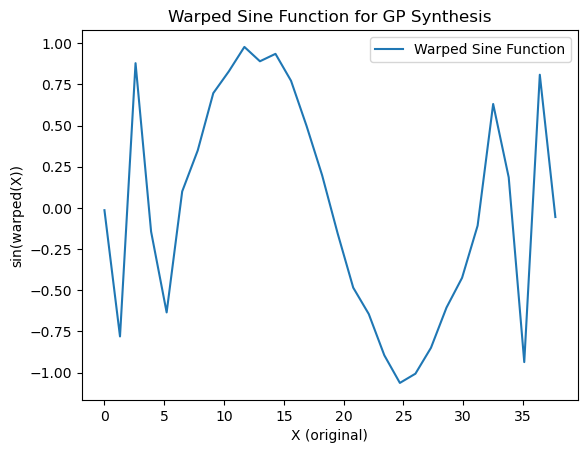

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 30).reshape(-1, 1)
y_train = warped_sine(X_train.flatten()) + 0.05 * random.normal(jax.random.PRNGKey(0), (30,))

X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

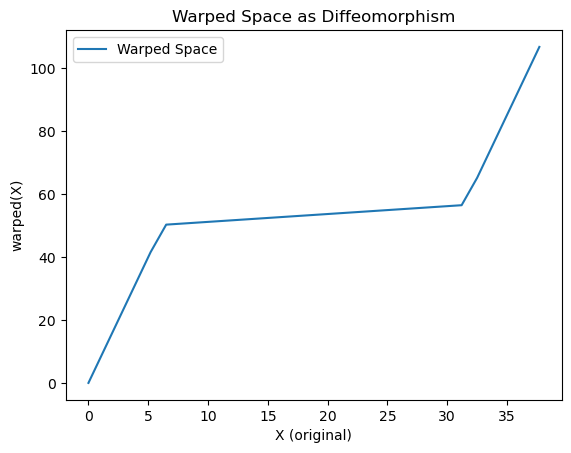

In [4]:
plt.plot(X_np, np.array(warp_vec(X_train)), label="Warped Space")
plt.title("Warped Space as Diffeomorphism")
plt.xlabel("X (original)")
plt.ylabel("warped(X)")
plt.legend()
plt.show()

In [5]:
block = [1,15,15]
layer_dims = block * 2 + [1]
layer_dims = [1,15, 15, 15, 15, 1]

key = jax.random.PRNGKey(0)

# net = ICNN_Grad(layer_dims, key)
net = MonotoneOperatorNet(layer_dims, key)

kernel = DeepKernel(net_fn=net)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [6]:
optimized_kernel_params, optimized_gp_params = optimize_mle(gp, state, kernel_params, gp_params, num_iters= 2500, learning_rate = 0.5)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 50, Loss: 36.9458
Iteration 100, Loss: 30.5731
Iteration 150, Loss: 30.5720
Iteration 200, Loss: 30.5719
Iteration 250, Loss: 30.5719
Iteration 300, Loss: 30.5719
Iteration 350, Loss: 30.5719
Iteration 400, Loss: 30.5719
Iteration 450, Loss: 30.5719
Iteration 500, Loss: 30.5719
Iteration 550, Loss: 30.5719
Iteration 600, Loss: 30.5719
Iteration 650, Loss: 30.5719
Iteration 700, Loss: 30.5719
Iteration 750, Loss: 30.5719
Iteration 800, Loss: 30.5719
Iteration 850, Loss: 30.5719
Iteration 900, Loss: 30.5719
Iteration 950, Loss: 30.5719
Iteration 1000, Loss: 30.5719
Iteration 1050, Loss: 30.5719
Iteration 1100, Loss: 30.5719
Iteration 1150, Loss: 30.5719
Iteration 1200, Loss: 30.5719
Iteration 1250, Loss: 30.5719
Iteration 1300, Loss: 30.5719
Iteration 1350, Loss: 30.5719
Iteration 1400, Loss: 30.5719
Iteration 1450, Loss: 30.5719
Iteration 1500, Loss: 30.5719
Iteration 1550, Loss: 30.5719
Iteration 1600, Loss: 30.5719
Iteration 1650, Loss: 30.5719
Iteration 1700, Loss: 30.5719


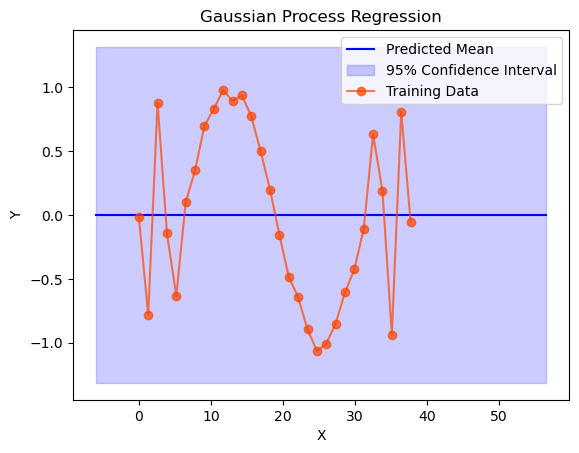

In [7]:
X_test = jnp.linspace(-6, 18 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, gp_params, X_test)
std_s = jnp.sqrt(cov_s)
# print(std_s)
plot_process(X_train, y_train, X_test, mu_s, std_s)

[[-4.4149176e+12 -4.4149359e+12 -4.4149600e+12 ... -4.4150979e+12
  -4.4148410e+12 -4.4149454e+12]
 [-4.3227509e+12 -4.3227687e+12 -4.3227923e+12 ... -4.3229273e+12
  -4.3226757e+12 -4.3227779e+12]
 [-4.2305837e+12 -4.2306015e+12 -4.2306243e+12 ... -4.2307564e+12
  -4.2305103e+12 -4.2306104e+12]
 ...
 [ 4.1391942e+13  4.1392114e+13  4.1392340e+13 ...  4.1393632e+13
   4.1391225e+13  4.1392202e+13]
 [ 4.1484108e+13  4.1484280e+13  4.1484502e+13 ...  4.1485798e+13
   4.1483386e+13  4.1484368e+13]
 [ 4.1576273e+13  4.1576445e+13  4.1576672e+13 ...  4.1577972e+13
   4.1575552e+13  4.1576538e+13]]


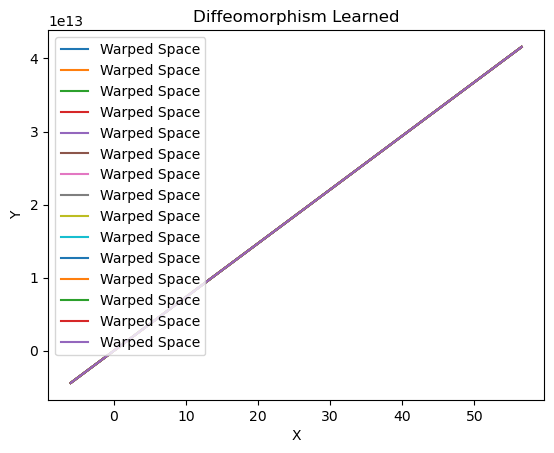

In [8]:
plot_diffeomorphism_1D(X_test, kernel, optimized_kernel_params)

In [9]:
print(optimized_kernel_params.log_alpha)
print(gp_params.noise)

-0.79989564
-9.615403
